epoch:[1/40],编码器码器的loss:127.9740 , 解码器的loss:18.0157
epoch:[2/40],编码器码器的loss:105.9351 , 解码器的loss:17.1343
epoch:[3/40],编码器码器的loss:102.2048 , 解码器的loss:16.6907
epoch:[4/40],编码器码器的loss:100.1623 , 解码器的loss:16.4152
epoch:[5/40],编码器码器的loss:98.8573 , 解码器的loss:16.2565
epoch:[6/40],编码器码器的loss:97.8987 , 解码器的loss:16.1211
epoch:[7/40],编码器码器的loss:97.1235 , 解码器的loss:16.0259
epoch:[8/40],编码器码器的loss:96.4811 , 解码器的loss:15.9412
epoch:[9/40],编码器码器的loss:95.9586 , 解码器的loss:15.8566
epoch:[10/40],编码器码器的loss:95.5262 , 解码器的loss:15.8078
epoch:[11/40],编码器码器的loss:95.1593 , 解码器的loss:15.7638
epoch:[12/40],编码器码器的loss:94.8453 , 解码器的loss:15.7526
epoch:[13/40],编码器码器的loss:94.5761 , 解码器的loss:15.6996
epoch:[14/40],编码器码器的loss:94.3185 , 解码器的loss:15.6511
epoch:[15/40],编码器码器的loss:94.1244 , 解码器的loss:15.6371
epoch:[16/40],编码器码器的loss:93.9312 , 解码器的loss:15.6007
epoch:[17/40],编码器码器的loss:93.7390 , 解码器的loss:15.5748
epoch:[18/40],编码器码器的loss:93.6017 , 解码器的loss:15.5715
epoch:[19/40],编码器码器的loss:93.4550 , 解码器的loss:15.5323
epoch:[20/40],编码器

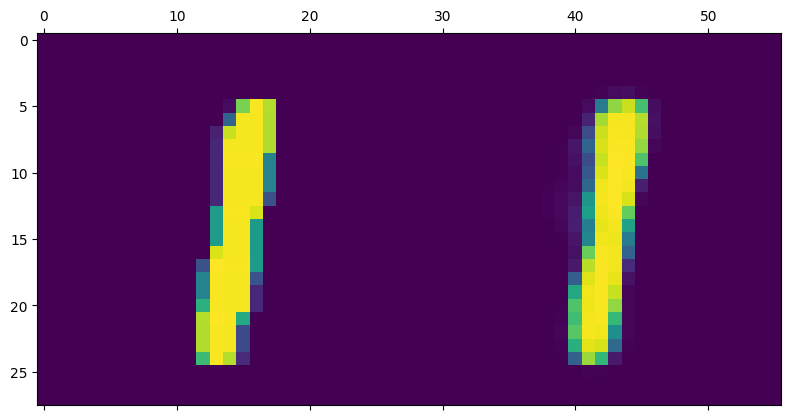

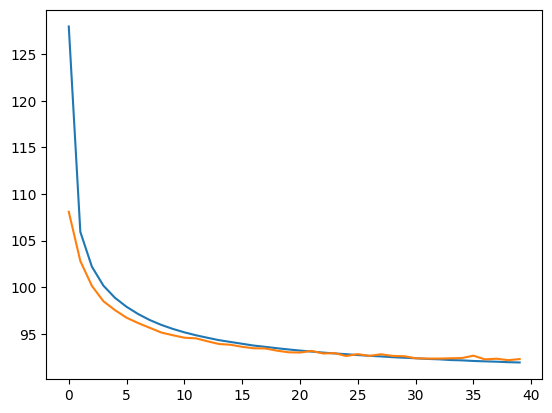

torch.Size([1, 784]) -> torch.Size([1, 8])


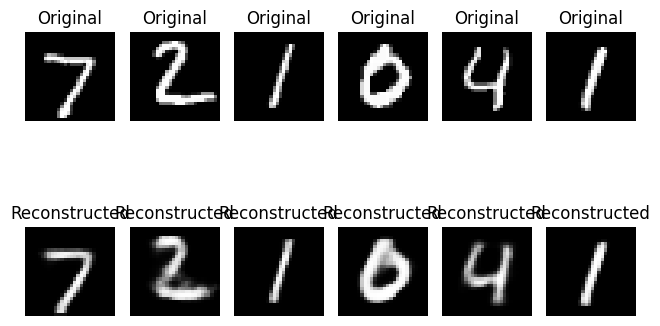

Average Train Reconstruction Loss: 454.6678
Average Test Reconstruction Loss: 461.2423


In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
# 定义了一个编码器模型，使用两个线性层将输入数据压缩到一个潜在空间中
class Encoder(torch.nn.Module):
    # 编码器，将input_size维度数据压缩为latent_size维度
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, latent_size)

    def forward(self, x):  # x: bs,input_size
        x = F.relu(self.linear1(x))  # -> bs,hidden_size
        x = self.linear2(x)  # -> bs,latent_size
        return x


# 解码器模型，它将潜在空间的数据解码成原始数据
class Decoder(torch.nn.Module):
    # 解码器，将latent_size维度的压缩数据转换为output_size维度的数据
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(latent_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):  # x:bs,latent_size
        x = F.relu(self.linear1(x))  # ->bs,hidden_size
        x = torch.sigmoid(self.linear2(x))  # ->bs,output_size
        return x


# 完整的自编码器模型，包含了编码器和解码器。输入数据首先通过编码器生成潜在特征，然后通过解码器进行重构
class AE(nn.Module):
    # 将编码器解码器组合，数据先后通过编码器、解码器处理
    def __init__(self, input_size, output_size, latent_size, hidden_size):
        super(AE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)

    def forward(self, x):  # x: bs,input_size
        feat = self.encoder(x)  # feat: bs,latent_size
        re_x = self.decoder(feat)  # re_x: bs, output_size
        return re_x

# 定义了两种损失函数，分别是二分类交叉熵损失和均方误差损失
# 交叉熵，衡量各个像素原始数据与重构数据的误差
loss_BCE = torch.nn.BCELoss(reduction='sum')
# 均方误差可作为交叉熵替代使用.衡量各个像素原始数据与重构数据的误差
loss_MSE = torch.nn.MSELoss(reduction='sum')

'超参数及构造模型'
# 模型参数
latent_size = 8  # 压缩后的特征维度
hidden_size = 128  # encoder和decoder中间层的维度
input_size = output_size = 28 * 28  # 原始图片和生成图片的维度

# 训练参数
epochs = 40  # 训练时期
batch_size = 32  # 每一步训练样本数
learning_rate = 1e-3  # 学习率
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 构建模型
model = AE(input_size, output_size, latent_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练数据加载器
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/data', train=True, download=True,transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)

# 测试数据加载器
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/data', train=False, transform=transforms.ToTensor()),batch_size=batch_size, shuffle=False)
all_train_loss = []
all_eval_loss = []
# 训练和测试的主要部分，包括了训练循环和测试循环
loss_history = {'train': [], 'eval': []}
for epoch in range(epochs):
    # 训练
    model.train()
    train_loss = 0
    train_nsample = 0
    for imgs, lbls in train_loader:
        bs = imgs.shape[0]
        imgs = imgs.to(device).view(bs, input_size)
        re_imgs = model(imgs)
        loss = loss_BCE(re_imgs, imgs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_nsample += bs
    print(f"epoch:[{epoch+1}/{epochs}],编码器码器的loss:{train_loss / train_nsample:.4f}",end=" , ")
    all_train_loss.append(train_loss / train_nsample)

    # 测试
    model.eval()
    test_loss = 0
    test_nsample = 0
    for imgs, label in test_loader:
        bs = imgs.shape[0]
        imgs = imgs.to(device).view(bs, input_size)
        re_imgs = model(imgs)
        loss = loss_BCE(re_imgs, imgs)
        test_loss += loss.item()
        test_nsample += bs
        # e.set_postfix({'loss': test_loss / test_nsample})
    print(f"解码器的loss:{test_loss / train_nsample:.4f}")
    all_eval_loss.append(test_loss / test_nsample)

    # 可视化展示
concat = torch.cat((imgs[0].view(28, 28),re_imgs[0].view(28, 28)), 1)
plt.matshow(concat.cpu().detach().numpy())
plt.show()

plt.plot(range(len(all_train_loss)), all_train_loss)
plt.plot(range(len(all_eval_loss)), all_eval_loss)
plt.show()
# 保存模型
torch.save(model.state_dict(), 'ae.pth')
# 从测试数据集中获取一个样本，并使用模型的编码器部分对该样本进行推断，得到潜在特征
# 调用模型
dataset = datasets.MNIST('/data', train=False, transform=transforms.ToTensor())
raw = dataset[0][0].view(1, -1)
raw = raw.to(device)

feat = model.encoder(raw)
print(raw.shape, '->', feat.shape)

# 计算训练集和测试集的重建误差并可视化重构图像
train_reconstruction_loss = []
test_reconstruction_loss = []

model.eval()
for data, _ in train_loader:
    data = data.to(device).view(data.size(0), -1)
    reconstructions = model(data)
    loss = loss_MSE(reconstructions, data)
    train_reconstruction_loss.append(loss.item())

for data, _ in test_loader:
    data = data.to(device).view(data.size(0), -1)
    reconstructions = model(data)
    loss = loss_MSE(reconstructions, data)
    test_reconstruction_loss.append(loss.item())

# 可视化重构图像
num_images_to_show = 6

model.eval()
for i in range(num_images_to_show):
    test_data = next(iter(test_loader))[0].to(device)
    test_data = test_data.view(test_data.size(0), -1)
    reconstruction = model(test_data)

    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(test_data[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + num_images_to_show + 1)
    plt.imshow(reconstruction[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 输出重建误差
avg_train_reconstruction_loss = sum(train_reconstruction_loss) / len(train_reconstruction_loss)
avg_test_reconstruction_loss = sum(test_reconstruction_loss) / len(test_reconstruction_loss)
print(f'Average Train Reconstruction Loss: {avg_train_reconstruction_loss:.4f}')
print(f'Average Test Reconstruction Loss: {avg_test_reconstruction_loss:.4f}')